In [2]:
from __future__ import annotations
import os
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from qtpyt.basis import Basis
import numpy as np
import matplotlib.pyplot as plt

[anooja-ThinkPad-X1-Carbon-Gen-11:26704] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


In [3]:
data_folder = './output/lowdin'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

GPWDEVICEDIR = './dft/device/'
GPWLEADSDIR = './dft/leads/'
SUBDIAG_SPECIES = ("C", "N", "H")
active = {'C': [3],'N': [3]}


cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

In [4]:
lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.8e+04


In [5]:
fermi

4.250216953329048

In [6]:
H_lcao.shape

(2394, 2394)

In [7]:
from scipy.sparse.linalg import eigs
num_eigenvalues = 4  # Number of eigenvalues to compute
target_energy = 0.0   # Energy around which to search for eigenvalues

# Ensure H_lcao is a numpy array
H_lcao = np.array(H_lcao)

# Compute eigenvalues near target_energy
eigenvalues, eigenvectors = eigs(H_lcao, M=S_lcao, k=num_eigenvalues, sigma=target_energy, which='LM')

# Print the results
print("Eigenvalues around {} eV:".format(target_energy))
print(eigenvalues)


Eigenvalues around 0.0 eV:
[ 0.00015041+0.j  0.00131038+0.j -0.00155135+0.j -0.02635065+0.j]


Total occupancy at -0.5 eV =  9.72771466629252
Total occupancy at 0 eV =  9.283931601445145
Total occupancy at 1e-3 eV =  10.945333379067918
Total occupancy at 1e-2 eV =  12.057933906359596
Total occupancy at 0.5 eV =  11.782034862013335


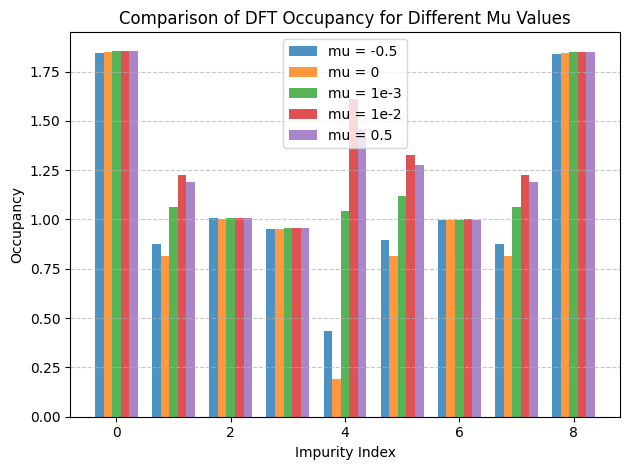

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Load occupancy data
occupancy_folder = "output/lowdin/occupancy"
occupancy1 = np.load(f"{occupancy_folder}/occupancies_gfloc_test_mu_0.npy")
occupancy2 = np.load(f"{occupancy_folder}/occupancies_gfloc_test_mu_0.001.npy")
occupancy3 = np.load(f"{occupancy_folder}/occupancies_gfloc_test_mu_0.01.npy")
occupancy4 = np.load(f"{occupancy_folder}/occupancies_gfloc_test_mu_-0.5.npy")
occupancy5 = np.load(f"{occupancy_folder}/occupancies_gfloc_test_mu_0.5.npy")

# Compute total occupancies
tot1 = np.sum(occupancy1)
tot2 = np.sum(occupancy2)
tot3 = np.sum(occupancy3)
tot4 = np.sum(occupancy4)
tot5 = np.sum(occupancy5)
print("Total occupancy at -0.5 eV = ", tot4)
print("Total occupancy at 0 eV = ", tot1)
print("Total occupancy at 1e-3 eV = ", tot2)
print("Total occupancy at 1e-2 eV = ", tot3)
print("Total occupancy at 0.5 eV = ", tot5)

bar_width = 0.15  # Reduce bar width to allow more bars per impurity

indices = np.arange(len(occupancy1))
# Plot the bar chart with adjusted positions
plt.bar(indices - 2 * bar_width, occupancy4, width=bar_width, label="mu = -0.5", alpha=0.8)
plt.bar(indices - bar_width, occupancy1, width=bar_width, label="mu = 0", alpha=0.8)
plt.bar(indices, occupancy2, width=bar_width, label="mu = 1e-3", alpha=0.8)
plt.bar(indices + bar_width, occupancy3, width=bar_width, label="mu = 1e-2", alpha=0.8)
plt.bar(indices + 2 * bar_width, occupancy5, width=bar_width, label="mu = 0.5", alpha=0.8)


# Add labels and title
plt.xlabel("Impurity Index")
plt.ylabel("Occupancy")
plt.title("Comparison of DFT Occupancy for Different Mu Values")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Position of DOS Peak position for mu = -0.5: 0.501 eV
Position of DOS Peak position for mu = 0: 0.001 eV
Position of DOS Peak position for mu = 1e-3: 0.0 eV
Position of DOS Peak position for mu = 1e-2: -0.009 eV
Position of DOS Peak position for mu = 0.5: -0.499 eV


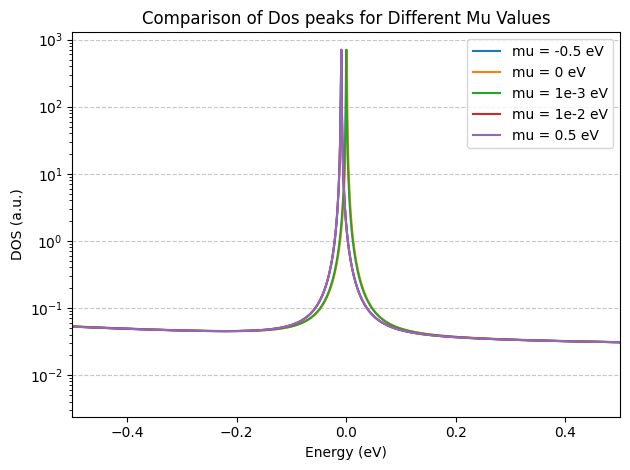

In [24]:
dos_folder = "output/lowdin/occupancy"
dos1 = np.load(f"{dos_folder}/dos_mu_0.npy")
dos2 = np.load(f"{dos_folder}/dos_mu_0.001.npy")
dos3 = np.load(f"{dos_folder}/dos_mu_0.01.npy")
dos4 = np.load(f"{dos_folder}/dos_mu_-0.5.npy")
dos5 = np.load(f"{dos_folder}/dos_mu_0.5.npy")
energies = np.load("output/lowdin/retarded_energies.npy")
energies = energies.real

# Define the energy range for peak finding
energy_range = (-1, 1)

# Find indices corresponding to the energy range
indices = (energies >= energy_range[0]) & (energies <= energy_range[1])

# Find peak positions within the energy range
peak_position1 = energies[indices][np.argmax(dos1[indices])]
peak_position2 = energies[indices][np.argmax(dos2[indices])]
peak_position3 = energies[indices][np.argmax(dos3[indices])]
peak_position4 = energies[indices][np.argmax(dos4[indices])]
peak_position5 = energies[indices][np.argmax(dos5[indices])]

# Print peak positions
print(f"Position of DOS Peak position for mu = -0.5: {peak_position4} eV")
print(f"Position of DOS Peak position for mu = 0: {peak_position1} eV")
print(f"Position of DOS Peak position for mu = 1e-3: {peak_position2} eV")
print(f"Position of DOS Peak position for mu = 1e-2: {peak_position3} eV")
print(f"Position of DOS Peak position for mu = 0.5: {peak_position5} eV")


plt.plot(energies, dos3, label="mu = -0.5 eV")
plt.plot(energies, dos1, label="mu = 0 eV")
plt.plot(energies, dos2, label="mu = 1e-3 eV")
plt.plot(energies, dos3, label="mu = 1e-2 eV")
plt.plot(energies, dos3, label="mu = 0.5 eV")


plt.xlabel("Energy (eV)")
plt.ylabel("DOS (a.u.)")
plt.title("Comparison of Dos peaks for Different Mu Values")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.5, 0.5)
plt.yscale('log')
plt.tight_layout()
plt.show()


### GFP

Total occupancy at 0 ev =  10.39874313147741
Total occupancy at 1e-3 ev =  10.787299188461677


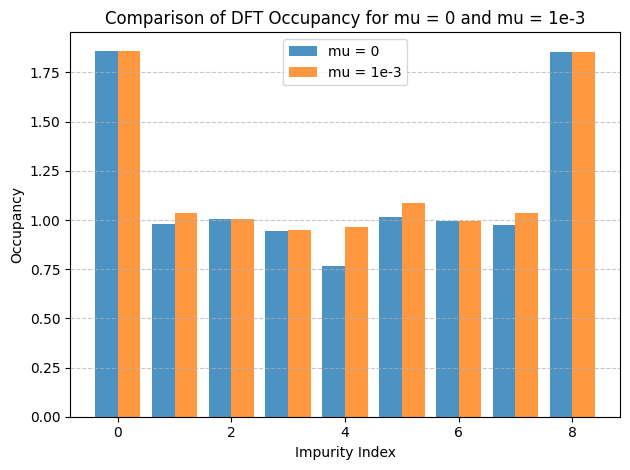

In [23]:
occupancy_folder = "output/lowdin/occupancy"
occupancy1 = np.load(f"{occupancy_folder}/occupancies_gfp_test_mu_0.npy")
occupancy2 = np.load(f"{occupancy_folder}/occupancies_gfp_test_mu_0.001.npy")

tot1 = np.sum(occupancy1)
tot2 = np.sum(occupancy2)
print("Total occupancy at 0 ev = ",tot1)
print("Total occupancy at 1e-3 ev = ",tot2)

indices = np.arange(len(occupancy1))

bar_width = 0.4
plt.bar(indices - bar_width/2, occupancy1, width=bar_width, label="mu = 0", alpha=0.8)
plt.bar(indices + bar_width/2, occupancy2, width=bar_width, label="mu = 1e-3", alpha=0.8)

plt.xlabel("Impurity Index")
plt.ylabel("Occupancy")
plt.title("Comparison of DFT Occupancy for mu = 0 and mu = 1e-3")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()